In [1]:
import import_ipynb
import Scanpy_functions_v03262021 as sc_pipe
import scvelo as scv
scv.logging.print_version()
import warnings
import scirpy as ir
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import bbknn
import logging
from sklearn.mixture import GaussianMixture
from scipy.stats     import norm
import glob
import os
import hvplot.pandas
import docx
from docx import Document
from docx.shared import Inches
from docx.shared import Pt
from scipy import sparse
import scanpy.external as sce
import holoviews as hv
import panel as pn
import bokeh
from bokeh.resources import INLINE
import scanorama
import gseapy

importing Jupyter notebook from Scanpy_functions_v03262021.ipynb
Running scvelo 0.2.4 (python 3.8.12) on 2022-06-06 13:02.
Running scvelo 0.2.4 (python 3.8.12) on 2022-06-06 13:03.


In [2]:
# define sample metadata. Usually read from a file.
exclude_genes = ['Rpl', 'Rps', 'Trav', 'Traj', 'Trbj', 'Trbv','Mrp','Fau','Dap3','Uba52','Ighv', 'Igkv', 'Iglv']


In_path = '/user/ifrec/liuyuchen/scRNASeq_DATA/Akira_Fukusima_scRNASeq/'

out_path = '/user/ifrec/liuyuchen/Analysis_Reports/Akira_Fukusima_scRNASeq/human/'

In [3]:
#sc.set_figure_params(scanpy=True, dpi=200,  figsize=[12.8,9.6])
sc.settings.verbosity = 3

In [4]:
scv.settings.set_figure_params("scvelo")

In [5]:
adata = sc.read_h5ad(out_path+'/human_merged.h5ad')
#mouse = sc.read_h5ad(out_path+'/mouse_labeled.h5ad')

In [6]:
useless_columns= [ 'Clusters', '_X', '_Y']
for uc in useless_columns:
    del adata.obs[uc]

In [7]:
adata.obs['Sample'].value_counts()

PBMC_TY38         21769
TY27_BAL          19581
BAL_TY-2          17907
Lung_HN-1         17652
BAL_TY-14         17445
BAL_TY-10         17286
PBMC_Healthy-3    16629
BAL_TY-7          16106
Lung_HN-2         15976
BAL_TY-20         15863
BAL_TY-12         15126
BAL_TY-11         14855
BAL_TY-09         13948
TY30_PBMC         13098
BAL_TY-4          12910
BAL_TY-17         11637
BAL_TY-8          11585
BAL_TY-19         10386
BAL_TY-6          10246
BAL_TY-5           9934
BAL_TY-3           9251
BAL_TY-16          8921
BAL_TY-1           8129
TY28_BAL           8089
BAL_TY-15          7278
Lung_HN10          5216
BAL_TY-13          4508
TY26_BAL           4016
Name: Sample, dtype: int64

In [8]:
adata = adata[~adata.obs['Sample'].isin(['BAL_TY-14','BAL_TY-10'])]

In [9]:
adata.obs['Sample'].value_counts()

PBMC_TY38         21769
TY27_BAL          19581
BAL_TY-2          17907
Lung_HN-1         17652
PBMC_Healthy-3    16629
BAL_TY-7          16106
Lung_HN-2         15976
BAL_TY-20         15863
BAL_TY-12         15126
BAL_TY-11         14855
BAL_TY-09         13948
TY30_PBMC         13098
BAL_TY-4          12910
BAL_TY-17         11637
BAL_TY-8          11585
BAL_TY-19         10386
BAL_TY-6          10246
BAL_TY-5           9934
BAL_TY-3           9251
BAL_TY-16          8921
BAL_TY-1           8129
TY28_BAL           8089
BAL_TY-15          7278
Lung_HN10          5216
BAL_TY-13          4508
TY26_BAL           4016
Name: Sample, dtype: int64

In [10]:
adata

View of AnnData object with n_obs × n_vars = 320616 × 29104
    obs: 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'Sample', 'batch', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'doublet_score', 'predicted_doublet', 'n_counts', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'log_counts', 'leiden', 'Cell_Type'
    var: 'gene_ids', 'feature_types', 'genome', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Cell_Type_colors', 'Sample_colors', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'leiden_sizes', 'log1p', 'neighbors', 'paga', 'pca', 'rank_genes_groups', 'ra

In [11]:
adata.obs['Cell_Type'].value_counts()

Macrophage                              134632
CD4+ Memory/Effector T                   63826
Natural Killer                           30045
CD8+ Naive T                             20439
Capillary Intermediate 2                 10627
Classical Monocyte                        7803
Bronchial Vessel 1                        6709
Capillary                                 6513
CD8+ Memory/Effector T                    4798
Natural Killer T                          3914
B                                         3690
Alveolar Epithelial Type 1                3104
Nonclassical Monocyte                     2193
Proliferating Macrophage                  2104
Ciliated                                  1836
Myeloid Dendritic Type 1                  1597
Club                                      1463
Proliferating NK/T                        1448
Basophil/Mast 1                           1333
Alveolar Epithelial Type 2                1294
Myeloid Dendritic Type 2                   974
Capillary Aer

In [12]:
sc.tl.leiden(adata, resolution=3,key_added='leiden_resol_3')

running Leiden clustering
    finished: found 47 clusters and added
    'leiden_resol_3', the cluster labels (adata.obs, categorical) (0:23:42)


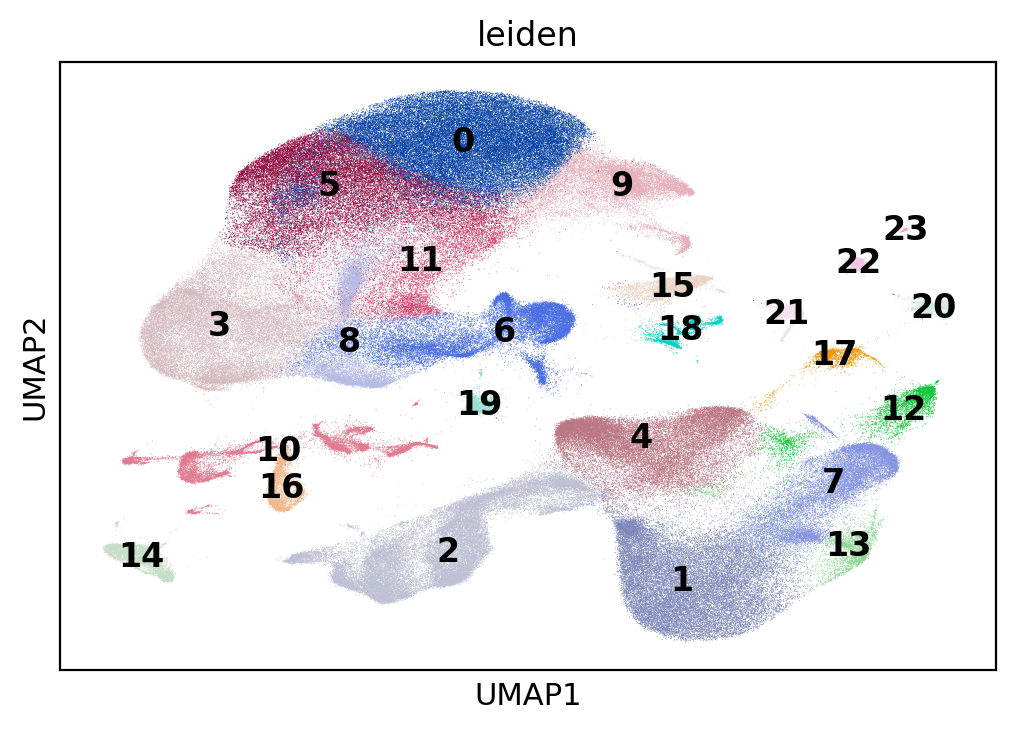

In [13]:
sc.pl.umap(adata,color='leiden',legend_loc = 'on data')

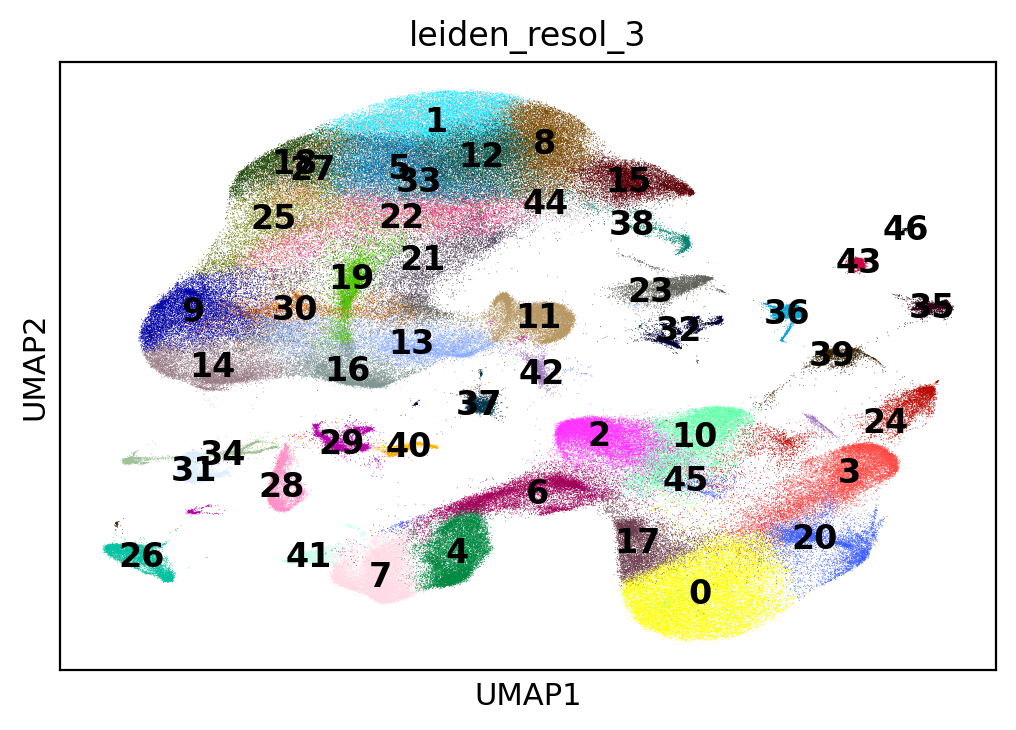

In [14]:
sc.pl.umap(adata,color='leiden_resol_3',legend_loc = 'on data')

In [15]:
adata.obs['Defined_type']='Others'
adata.obs.loc[adata.obs['leiden'].isin(['0','9','5']),'Defined_type']='Resident macrophage'
adata.obs.loc[adata.obs['leiden']=='11','Defined_type']='Resident macrophage Sub-population'
adata.obs.loc[adata.obs['leiden']=='3','Defined_type']='FMC macrophage'
adata.obs.loc[adata.obs['leiden']=='6','Defined_type']='Monocyte Macrophage'
adata.obs.loc[adata.obs['leiden']=='10','Defined_type']='Epithelial and endothelial cells'
adata.obs.loc[adata.obs['leiden']=='16','Defined_type']='Proliferating macrophage'
adata.obs.loc[adata.obs['leiden']=='14','Defined_type']='B cells'
adata.obs.loc[adata.obs['leiden']=='15','Defined_type']='CLEC10A+CD1c+CLEC9A+'
adata.obs.loc[adata.obs['leiden']=='19','Defined_type']='CLEC9A+ DC'
adata.obs.loc[adata.obs['leiden']=='18','Defined_type']='Fibroblast'
adata.obs.loc[adata.obs['leiden_resol_3']=='11','Defined_type']='Classical Monocyte'
adata.obs.loc[(adata.obs['leiden_resol_3']=='11')&(adata.obs['Cell_Type']=='Nonclassical Monocyte'),'Defined_type']='Nonclassical Monocyte'
adata.obs.loc[adata.obs['leiden_resol_3']=='42','Defined_type']='Intermediate Monocyte'
adata.obs.loc[adata.obs['leiden']=='12','Defined_type']='Regulatory T cell FoxP3+'
adata.obs.loc[adata.obs['leiden'].isin(['7','1','13']),'Defined_type']='CD4 T cell'
adata.obs.loc[adata.obs['leiden_resol_3'].isin(['2','6','10','45']),'Defined_type']='CD8 T cell'
adata.obs.loc[adata.obs['leiden_resol_3']=='4','Defined_type']='NKT cell'
adata.obs.loc[adata.obs['leiden_resol_3'].isin(['7','41']),'Defined_type']='NK cell'
adata.obs.loc[adata.obs['leiden']=='8','Defined_type'] = 'MDA5 specific macrophage'
#Try to define the subset of Monocytes with marker genes
adata.obs.loc[adata.obs['leiden']=='20','Defined_type'] = 'Basophil/Mast cell'
adata.obs.loc[adata.obs['leiden']=='17','Defined_type'] = 'Proliferating T cell'
adata.obs.loc[adata.obs['leiden']=='21','Defined_type'] = 'B cell (Memory/Plasma)'
adata.obs.loc[adata.obs['leiden']=='22','Defined_type'] = 'pDC'
adata.obs.loc[adata.obs['leiden']=='23','Defined_type'] = 'Lymphatic endothelial cells'


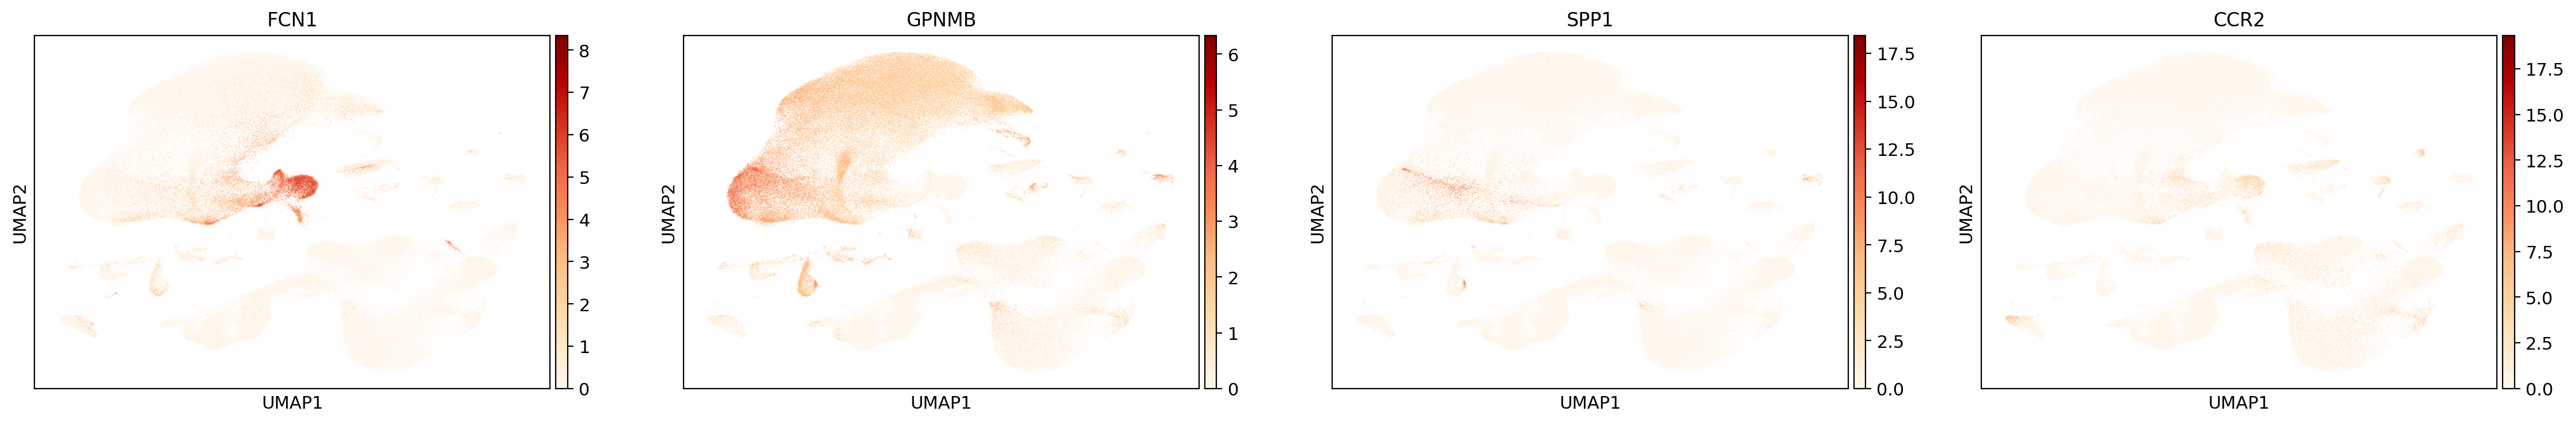

In [16]:
sc.pl.umap(adata,color=['FCN1','GPNMB','SPP1','CCR2'],cmap='OrRd',use_raw=False)

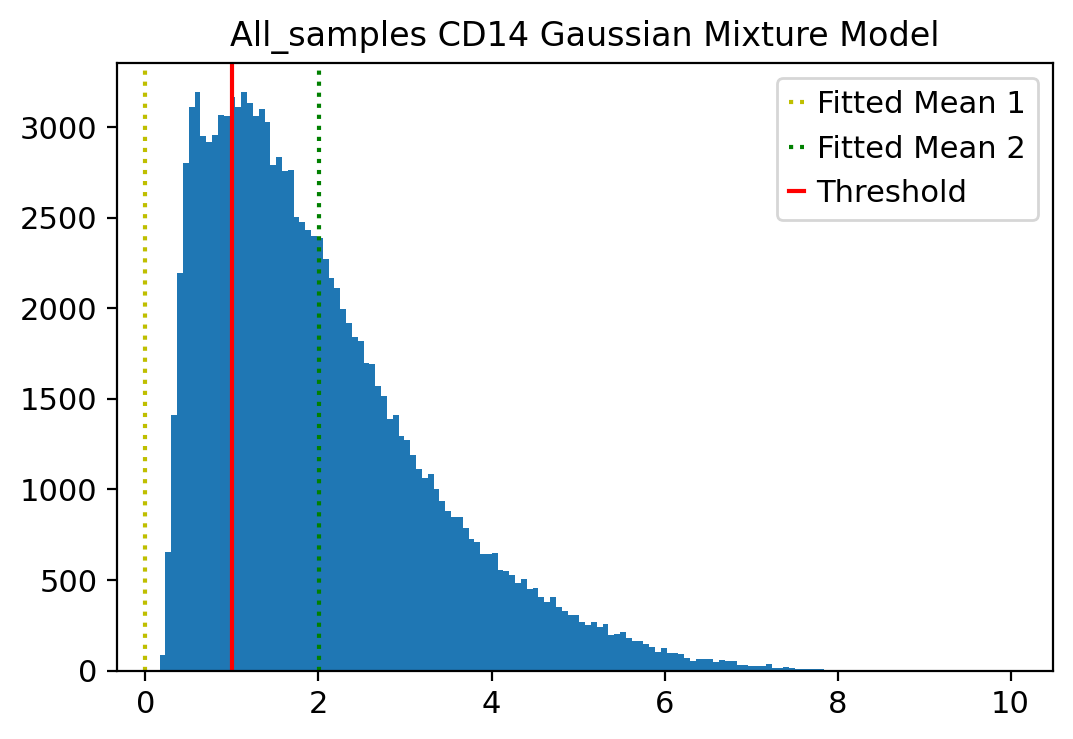

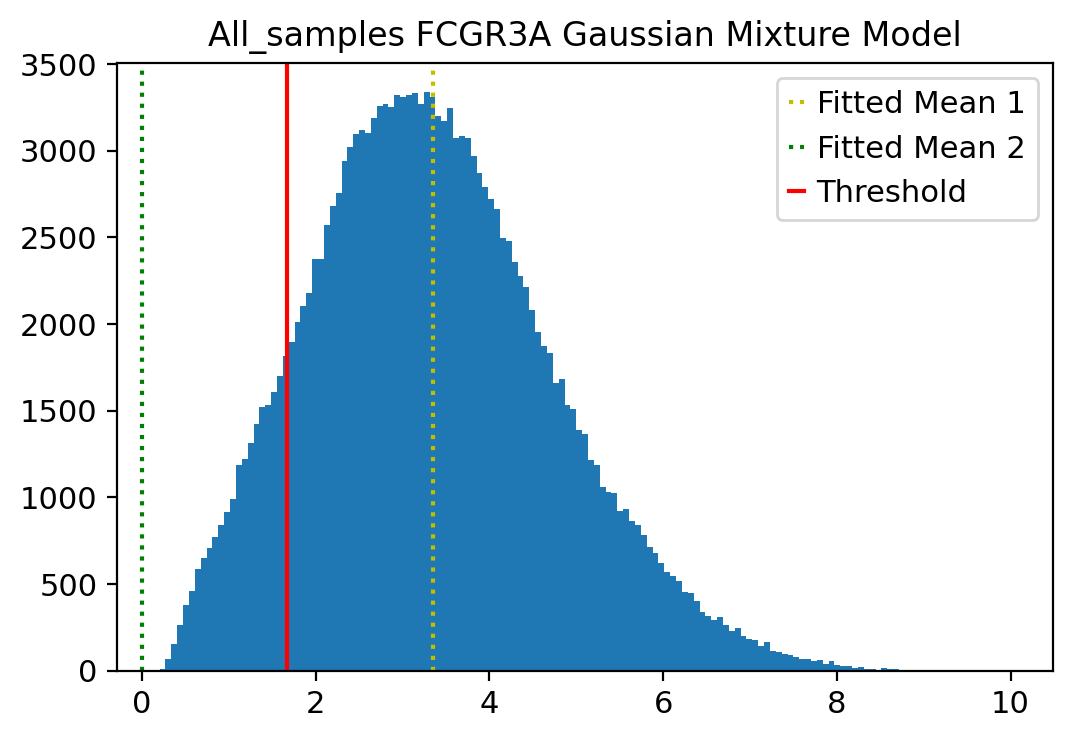

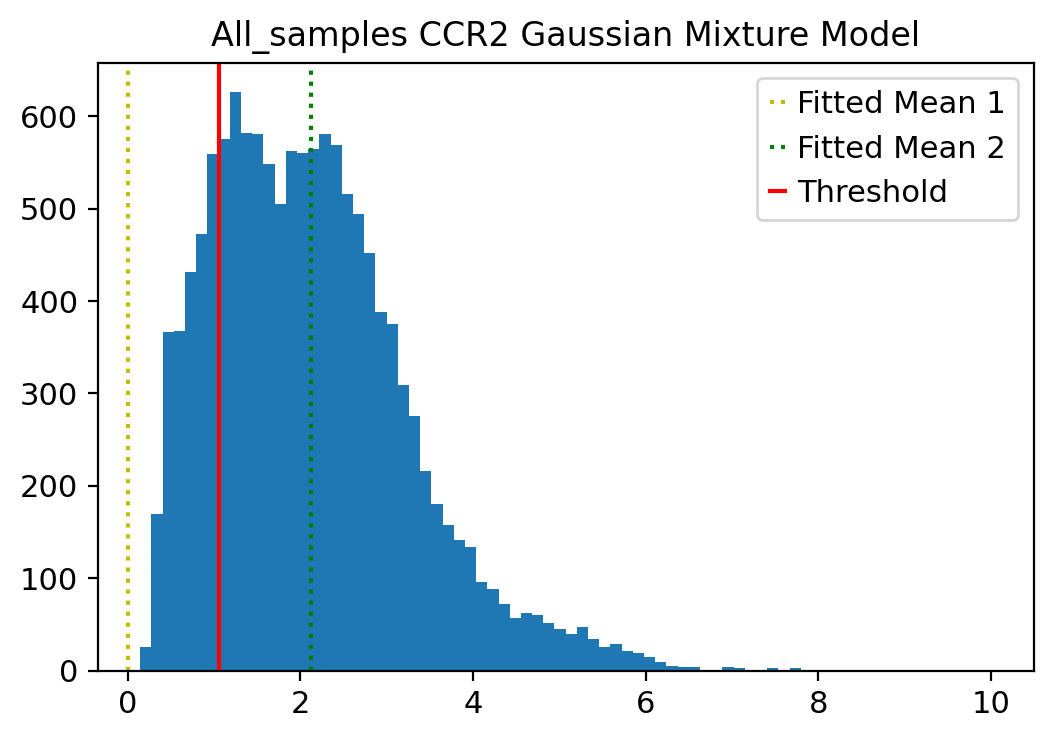

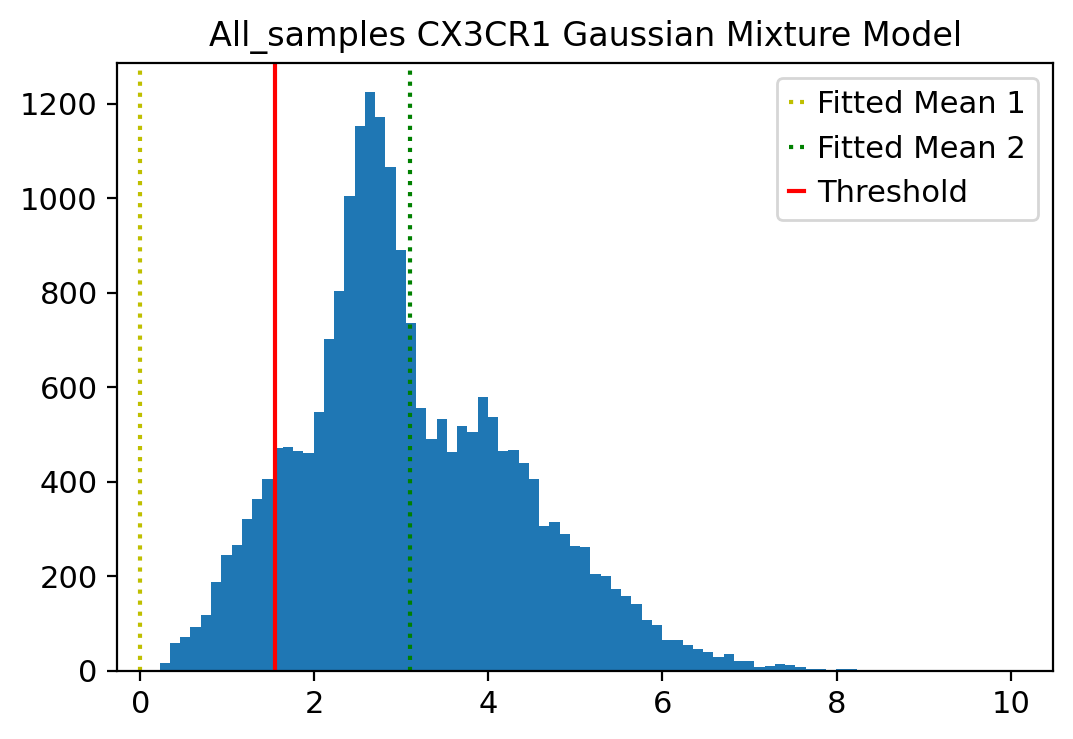

In [17]:
Factors = ['CD14', 'FCGR3A','CCR2','CX3CR1']
adata.obs['Monocyte_factors'] = 'Type_'
for f in Factors:
    delta, var, cut_off,up_bound,low_bound= sc_pipe.Thrshold_by_Gaussian_with_plot(adata, f,out_path, 'All_samples', sparse = True)
    data = adata[:, f].X.A
    data =  np.interp(data, (data.min(), data.max()), (0, 10))
    adata.obs[f+'_binary'] = np.where(data > cut_off, f+'+', f+'-')
    adata.obs['Monocyte_factors'] =adata.obs['Monocyte_factors']+'_'+adata.obs[f+'_binary']

In [18]:
adata.obs['Monocyte_factors'].value_counts()

Type__CD14-_FCGR3A-_CCR2-_CX3CR1-    132195
Type__CD14-_FCGR3A+_CCR2-_CX3CR1-     70888
Type__CD14+_FCGR3A+_CCR2-_CX3CR1-     64141
Type__CD14+_FCGR3A-_CCR2-_CX3CR1-     23377
Type__CD14-_FCGR3A+_CCR2-_CX3CR1+     14669
Type__CD14-_FCGR3A-_CCR2+_CX3CR1-      5635
Type__CD14-_FCGR3A-_CCR2-_CX3CR1+      3394
Type__CD14+_FCGR3A-_CCR2+_CX3CR1-      1828
Type__CD14+_FCGR3A+_CCR2+_CX3CR1-      1729
Type__CD14-_FCGR3A+_CCR2+_CX3CR1-       847
Type__CD14+_FCGR3A-_CCR2-_CX3CR1+       707
Type__CD14+_FCGR3A+_CCR2-_CX3CR1+       585
Type__CD14+_FCGR3A-_CCR2+_CX3CR1+       227
Type__CD14-_FCGR3A-_CCR2+_CX3CR1+       183
Type__CD14+_FCGR3A+_CCR2+_CX3CR1+       126
Type__CD14-_FCGR3A+_CCR2+_CX3CR1+        85
Name: Monocyte_factors, dtype: int64

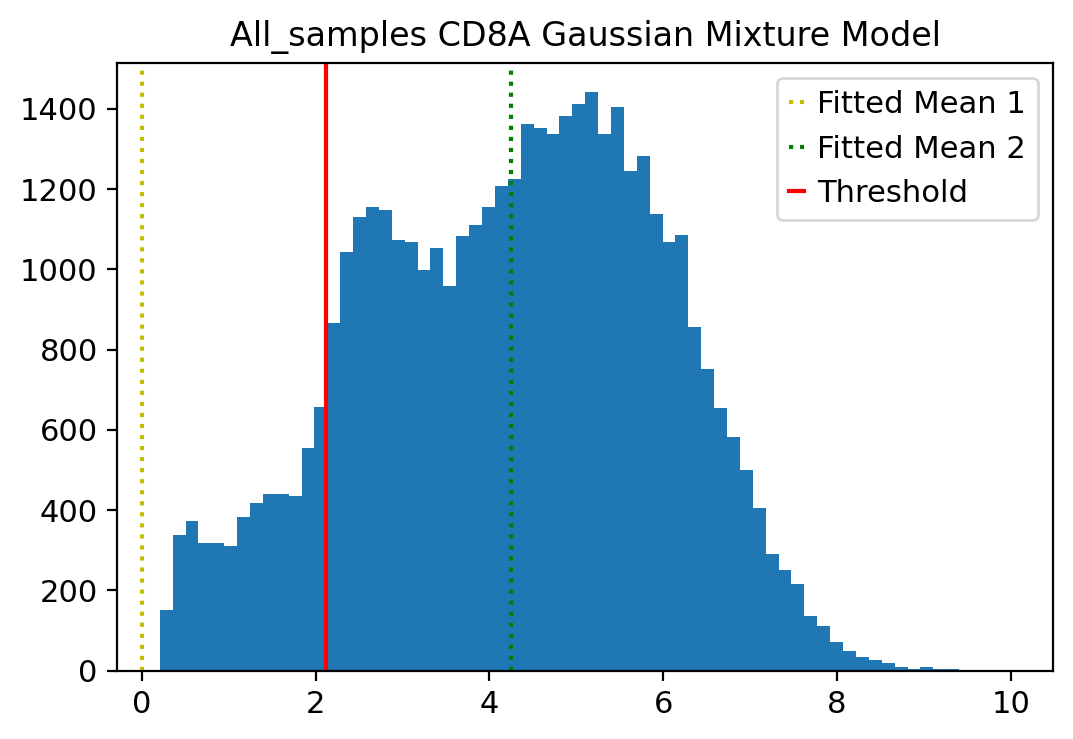

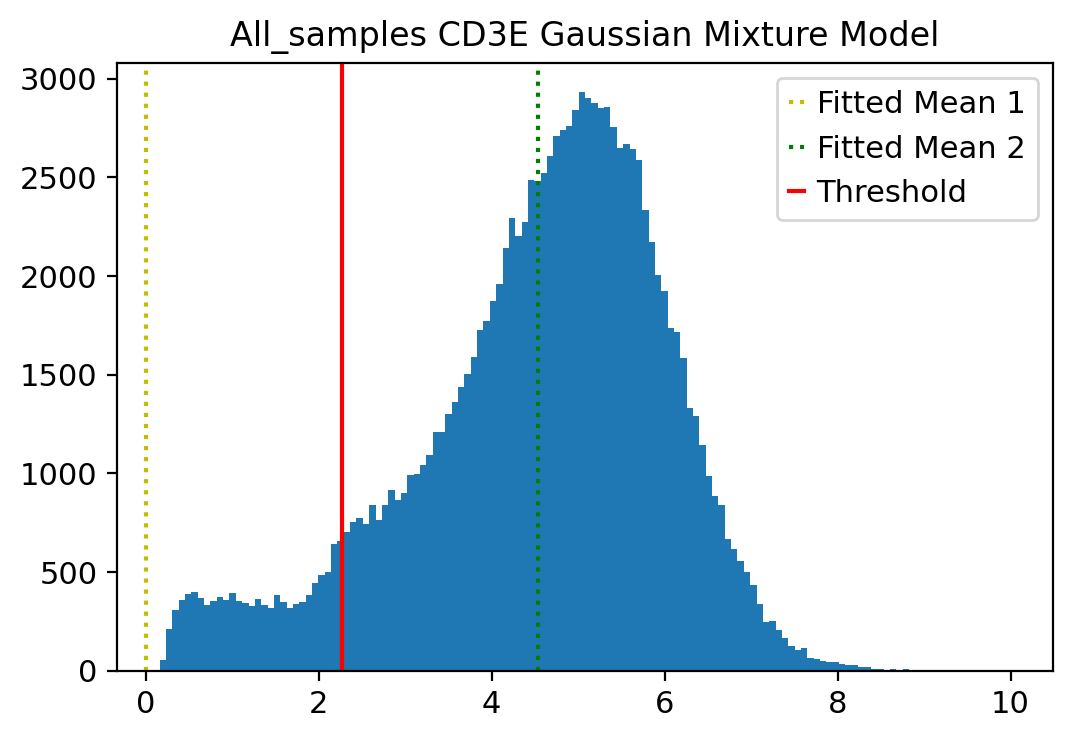

In [19]:
Factors = ['CD8A','CD3E']
adata.obs['Tcell_factors'] = 'Type_'
for f in Factors:
    delta, var, cut_off,up_bound,low_bound= sc_pipe.Thrshold_by_Gaussian_with_plot(adata, f,out_path, 'All_samples', sparse = True)
    data = adata[:, f].X.A
    data =  np.interp(data, (data.min(), data.max()), (0, 10))
    adata.obs[f+'_binary'] = np.where(data > cut_off, f+'+', f+'-')
    adata.obs['Tcell_factors'] =adata.obs['Tcell_factors']+'_'+adata.obs[f+'_binary']

In [20]:
adata.obs['Tcell_factors'].value_counts()

Type__CD8A-_CD3E-    205706
Type__CD8A-_CD3E+     76751
Type__CD8A+_CD3E+     35146
Type__CD8A+_CD3E-      3013
Name: Tcell_factors, dtype: int64

In [21]:
adata.obs.loc[adata.obs['Tcell_factors']=='Type__CD8A+_CD3E+','Defined_type']='CD8 T cell'

In [22]:
adata.obs.loc[adata.obs['leiden_resol_3']=='42','Tcell_factors'].value_counts()

Type__CD8A-_CD3E+    1179
Type__CD8A-_CD3E-     542
Type__CD8A+_CD3E+     193
Type__CD8A+_CD3E-      40
Name: Tcell_factors, dtype: int64

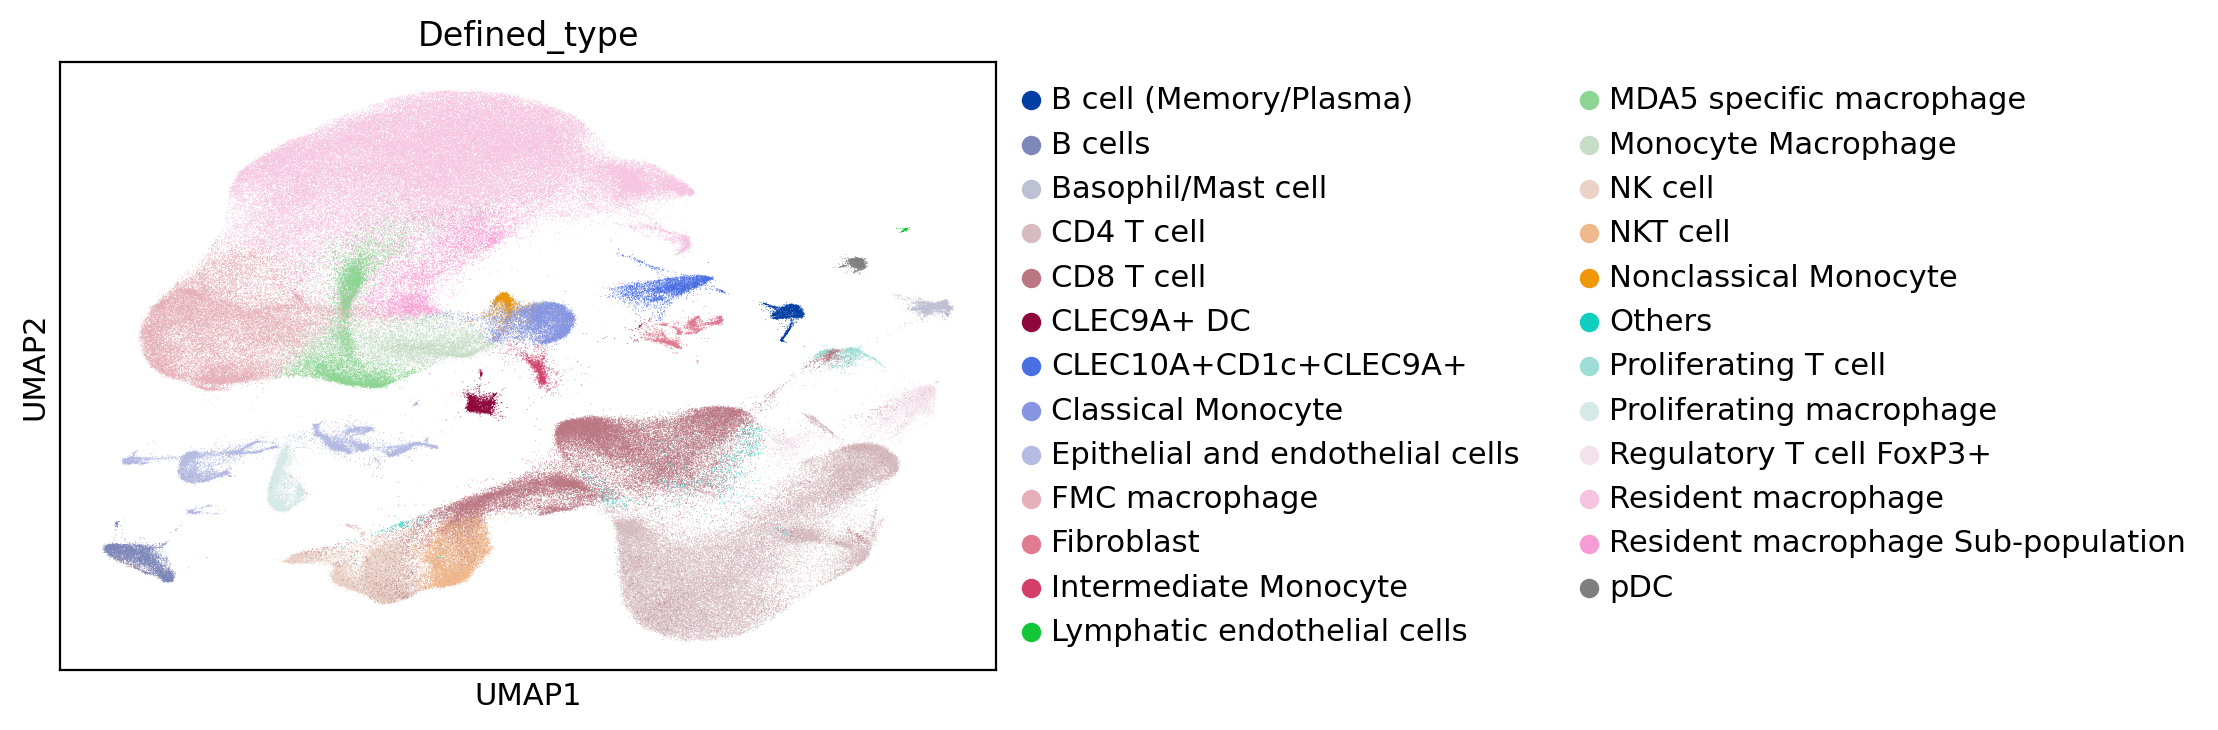

In [23]:
sc.pl.umap(adata,color='Defined_type')

In [24]:
adata.obs['Defined_type'].value_counts()

Resident macrophage                   85558
CD4 T cell                            46600
CD8 T cell                            45127
FMC macrophage                        29519
MDA5 specific macrophage              14130
Epithelial and endothelial cells      13379
NK cell                               11365
NKT cell                              10481
Resident macrophage Sub-population     9615
Monocyte Macrophage                    8773
Classical Monocyte                     8509
B cells                                5681
Proliferating macrophage               4813
Regulatory T cell FoxP3+               4708
CLEC10A+CD1c+CLEC9A+                   4157
Fibroblast                             2779
CLEC9A+ DC                             2570
B cell (Memory/Plasma)                 2554
Basophil/Mast cell                     2454
Nonclassical Monocyte                  1831
Proliferating T cell                   1536
pDC                                    1405
Intermediate Monocyte           

In [25]:
adata.write(out_path+'/human_merged_0602.h5ad')

In [26]:

from pyBCS import scanpy2bcs
scanpy2bcs.format_data(out_path+'/human_merged_0602.h5ad', out_path+'/human_merged_0602.bcs',
                        input_format="h5ad", graph_based="leiden")


Writing main/metadata/metalist.json
Cannot convert Sample to numeric, treating as categorical
Cannot convert leiden to numeric, treating as categorical
Cannot convert Cell_Type to numeric, treating as categorical
Cannot convert Defined_type to numeric, treating as categorical
Cannot convert Monocyte_factors to numeric, treating as categorical
Cannot convert CD14_binary to numeric, treating as categorical
Cannot convert FCGR3A_binary to numeric, treating as categorical
Cannot convert CCR2_binary to numeric, treating as categorical
Cannot convert CX3CR1_binary to numeric, treating as categorical
Cannot convert Tcell_factors to numeric, treating as categorical
Cannot convert CD8A_binary to numeric, treating as categorical
Cannot convert CD3E_binary to numeric, treating as categorical
"predicted_doublet" is not numeric or categorical, ignoring
Found graph based clustering in metadata with keyword leiden
Writing main/metadata/15fc8e8e230d460093b9d51693c8311f.json
Writing main/metadata/5545d

'/user/ifrec/liuyuchen/Analysis_Reports/Akira_Fukusima_scRNASeq/human//human_merged_0602.bcs'

In [27]:
adata.obs['Defined_type'].to_csv('./Defined_type.csv')

In [ ]:
scv.pp.moments(adata)
scv.tl.recover_dynamics(adata)
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)
scv.tl.score_genes_cell_cycle(adata)
scv.pl.scatter(adata, color_gradients=['S_score', 'G2M_score'], smooth=True, perc=[5, 95])
scv.tl.velocity_confidence(adata)
keys = 'velocity_length', 'velocity_confidence'
scv.pl.scatter(adata, c=keys, cmap='coolwarm', perc=[5, 95])



In [ ]:
adata

In [ ]:
sc.tl.paga(adata, groups='leiden')

In [ ]:
scv.pl.paga(adata, basis='umap')

In [ ]:
scv.pl.velocity_embedding_stream(adata, basis='umap',color = 'leiden')

In [ ]:
del adata.obs['predicted_doublet']
adata.write(out_path+'/human_velocity_integrated_all_sample.h5ad')

In [ ]:
scv.tl.latent_time(adata)
scv.pl.scatter(adata, color='latent_time', color_map='gnuplot', size=80)
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index[:300]
scv.pl.heatmap(adata, var_names=top_genes, sortby='latent_time', col_color='leiden', n_convolve=100)
#scv.tl.paga(adata, groups='leiden',use_time_prior='latent_time')
#scv.pl.paga(adata, basis='human_clusters', size=50, alpha=.1, min_edge_width=2, node_size_scale=1.5)

In [ ]:
scv.pl.proportions(adata,groupby='Sample',layers=['ambiguous', 'spliced', 'unspliced'])

In [ ]:
adata.write(out_path+'/human_velocity_integrated_all_sample.h5ad')